In [0]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets as datasets, models ,transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
#from collections import OrderedDict
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
PATH_OF_DATA= '/content/gdrive/"My Drive/Colab Notebooks/dogs_cats_images/dataset"'
!ls {PATH_OF_DATA}

test_set  training_set


In [0]:
image_size=224

In [0]:
data_transforms = transforms.Compose([
                    transforms.Resize((image_size,image_size)),
                    transforms.ToTensor()])

In [0]:
train_datasets = datasets.ImageFolder(root= '/content/gdrive/My Drive/Colab Notebooks/dogs_cats_images/dataset/training_set', transform=data_transforms)
test_datasets = datasets.ImageFolder(root= '/content/gdrive/My Drive/Colab Notebooks/dogs_cats_images/dataset/test_set', transform=data_transforms)

In [0]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle=True,)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=256, shuffle=True,)
print(len(train_loader))
print(len(test_loader))

125
8


In [0]:
train=iter(train_loader)
images,labels=next(train)

In [0]:
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


Text(0.5, 1.0, 'tensor(1)')

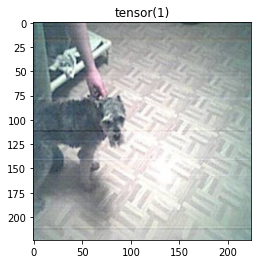

In [0]:
plt.imshow(images[6].permute(1, 2, 0)) # to display colored images, RGB.
plt.title(labels[6])

In [0]:
model=models.resnet18(pretrained=True)

In [0]:
#model

In [0]:
for params in model.parameters():
  params.requires_grad=False

In [0]:
classifier=nn.Sequential(nn.Linear(512,256),nn.ReLU(),nn.Dropout(p=0.2),nn.Linear(256,2),nn.LogSoftmax(dim=1))

In [0]:
model.fc=classifier

In [0]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
use_cuda=True
if torch.cuda.is_available:
  model.cuda()

In [0]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
optimizer=optim.Adam(model.fc.parameters(),lr=0.008)
criterion=nn.NLLLoss()

In [0]:
loss_at_epoch_training=np.array([])
loss_at_epoch_testing=np.array([])

In [0]:
epochs=250

In [0]:
for i in range(epochs):
  print(i)
  training_loss=0
  testing_loss=0
  start=time.time()
  for images,labels in train_loader:
    images = images.cuda()
    labels = labels.cuda()

    #train_examples_data1=images.view(images.shape[0],-1)
    optimizer.zero_grad()

    logProbs=model(images)

    loss=criterion(logProbs,labels)

    training_loss+=loss

    loss.backward()
    
    optimizer.step()
  end=time.time()
  print("Elapsed time for training epoch:",(end-start))
  start=time.time()
  with torch.no_grad():
    model.eval()
    for images,labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()
      #test_examples_data2=images.view(images.shape[0],-1)

      logProbs=model(images)
        
      loss=criterion(logProbs,labels)

      testing_loss+=loss
  model.train()
  end=time.time()
  print("Elapsed time for testing epoch:",(end-start))
  training_loss=training_loss/len(train_loader)
  testing_loss=testing_loss/len(test_loader)
  print("training_loss",training_loss)
  print("testing_loss",testing_loss)
  loss_at_epoch_training=np.append(loss_at_epoch_training,training_loss.cpu().detach().numpy())
  loss_at_epoch_testing=np.append(loss_at_epoch_testing,testing_loss.cpu().numpy())
  torch.save(model.state_dict,'model_dogvscat_resnet18.pth')

0
Elapsed time for training epoch: 48.03003644943237
Elapsed time for testing epoch: 11.529233694076538
training_loss tensor(0.2220, device='cuda:0', grad_fn=<DivBackward0>)
testing_loss tensor(0.0600, device='cuda:0')
1
Elapsed time for training epoch: 46.985477447509766
Elapsed time for testing epoch: 11.368816614151001
training_loss tensor(0.0833, device='cuda:0', grad_fn=<DivBackward0>)
testing_loss tensor(0.0566, device='cuda:0')
2
Elapsed time for training epoch: 46.87045454978943
Elapsed time for testing epoch: 11.442747116088867
training_loss tensor(0.0848, device='cuda:0', grad_fn=<DivBackward0>)
testing_loss tensor(0.0659, device='cuda:0')
3
Elapsed time for training epoch: 46.768425941467285
Elapsed time for testing epoch: 11.623711585998535
training_loss tensor(0.0711, device='cuda:0', grad_fn=<DivBackward0>)
testing_loss tensor(0.0618, device='cuda:0')
4
Elapsed time for training epoch: 47.84771013259888
Elapsed time for testing epoch: 11.507775068283081
training_loss tens

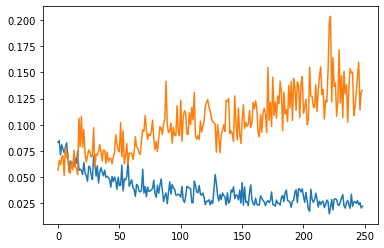

In [0]:
plt.plot(loss_at_epoch_training[1:], label="training")
plt.plot(loss_at_epoch_testing[1:], label="testing")
plt.show()

In [0]:
#Classsssic classic case of over fitting in the classifier layer but rest of the network is ofcourse very good so its still giving the accuracy of 98%

In [0]:
def PrintProbOutput(data):
  data=data.cpu().detach().numpy()
  x=torch.Tensor(range(0,2))
  print (data)
  print (x)
  #plt.bar(x.view(1,10),Probs)
  #sns.distplot(a=Probs,hist=True)
  plt.scatter(x.view(1,2),data)
  plt.ylim(0,1)
  plt.show

In [0]:
batch,(test_examples_data,test_examples_targets)=next(enumerate(test_loader))

In [0]:
if use_cuda and torch.cuda.is_available():
      test_examples_data = test_examples_data.cuda()
      test_examples_targets = test_examples_targets.cuda()

In [0]:
with torch.no_grad():
  output=model(images)
  #print(output)
  output=torch.exp(output)
print(output.shape)

torch.Size([208, 2])


Text(0.5, 1.0, "tensor(1, device='cuda:0')")

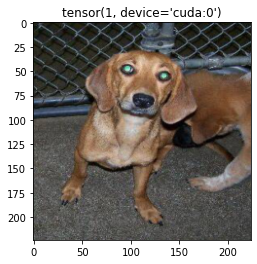

In [0]:
number=145
plt.imshow(test_examples_data[number].cpu().permute(1, 2, 0)) # to display colored images, RGB.
plt.title(test_examples_targets[number])

[1.2397555e-04 9.9987602e-01]
tensor([0., 1.])


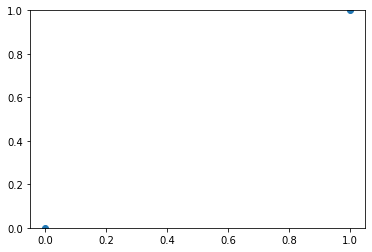

In [0]:
PrintProbOutput(output[number])

In [0]:
def CalculatedOutput(output):
  output=output.cpu().numpy()
  highest=-1
  rank=-1
  for i in range(len(output)):
    if output[i]>highest:
      highest=output[i]
      rank=i
  return np.array([rank])
def Accuracy(calc,exp):
  calc_output=np.array([])
  for i in range(exp.shape[0]):
    calc_output=np.append(calc_output,CalculatedOutput(calc[i]))
  exp_output=exp.cpu().numpy() #Converts into an numpy array
  accuracy=100*(np.sum(calc_output==exp_output)/exp.shape[0])
  return accuracy

In [0]:
count=0
for images,labels in test_loader:
  count+=1
  images=images.cuda()
  labels=labels.cuda()
  with torch.no_grad():
    output=model(images)
  print("Testing Accuracy of model for batch", count,":",Accuracy(output,labels))
count=0
for images,labels in train_loader:
  count+=1
  images=images.cuda()
  labels=labels.cuda()
  with torch.no_grad():
    output=model(images)
  print("Training Accuracy of model for batch", count,":",Accuracy(output,labels))
  if count==8:
    break

Testing Accuracy of model for batch 1 : 98.828125
Testing Accuracy of model for batch 2 : 96.875
Testing Accuracy of model for batch 3 : 98.4375
Testing Accuracy of model for batch 4 : 97.65625
Testing Accuracy of model for batch 5 : 96.875
Testing Accuracy of model for batch 6 : 97.265625
Testing Accuracy of model for batch 7 : 97.65625
Testing Accuracy of model for batch 8 : 98.5576923076923
Training Accuracy of model for batch 1 : 100.0
Training Accuracy of model for batch 2 : 100.0
Training Accuracy of model for batch 3 : 100.0
Training Accuracy of model for batch 4 : 100.0
Training Accuracy of model for batch 5 : 93.75
Training Accuracy of model for batch 6 : 100.0
Training Accuracy of model for batch 7 : 96.875
Training Accuracy of model for batch 8 : 100.0
